## Example: Detecting changes in mean of a stream of bounded observations

We consider the following problem: 
* We are given a stream of independent $[0, 1]$-valued observations, $X_1, X_2, \ldots$
* At some "changepoint" $T$, at which the mean of the distribution changes from $\mu_0$ to $\mu_1$. All these three terms, $T$, $\mu_0$, and $\mu_1$ are unknown to us. 
* We want to develop a stopping rule, $\tau$, which ensures that 
    * If $T=\infty$ or $0$ (or there is no change), then $\mathbb{E}[\tau]$ is large; at least $1/\alpha$ for some given $\alpha \in (0,1)$. 
    * Otherwise, if $T<\infty$, then the detection delay, $\mathbb{E}[(\tau-T)^+]$ is as small as possible. 


In this example, we compare the performance of two instantiations of the general change-detection meta-algorithm~(called `Repeated-FCS-detector`) introduced in Definition 2.1 of [Shekhar and Ramdas (2023)](https://arxiv.org/pdf/2309.09111.pdf). In particular, we compare 
1. Instantiation of `Repeated-FCS-detector` with Hoeffding Confidence Sequences (CS) introduced in Prop. 1 of [Waudby-Smith and Ramdas (2023)](https://arxiv.org/pdf/2010.09686.pdf)
1. Instantiation of `Repeated-FCS-detector` with Empirical-Bernstein Confidence Sequences (CS) introduced in Theorem 1 of [Waudby-Smith and Ramdas (2023)](https://arxiv.org/pdf/2010.09686.pdf)


In particular, we compare their performance in the following three experiments: 
* Experiment1: Comparison of Rejection rates when there is no changepoint 
* Experiment2: Comparison of Detection Delays under a fixed change $\Delta$
* Experiment3: Variation of their Detection Delays with changing $\Delta$. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from utils import createBoundedSource, evaluateExpt
from main import BoundedMeanBernsteinSCD, BoundedMeanHoeffdingSCD

############## Experiment1: No change in distribution ##############

mu0 = 0.6 # pre-change mean 
Nmax = 1000 #maximum horizon to run one trial
alpha = 0.005
source1 = createBoundedSource(change_point=0, mu0=mu0, mu1=mu0) 

# initialize the two change-detection-schemes for bounded observations
HoeffSCD = BoundedMeanHoeffdingSCD(source1, Nmax, progress_bar=True,
                                    max_num_CSs=Nmax, alpha=alpha)
BernSCD = BoundedMeanBernsteinSCD(source1, Nmax, progress_bar=True,
                                    max_num_CSs=Nmax, alpha=alpha)
                        
# run the experiments 
num_trials=100
FlagH1, TimesH1 = HoeffSCD.run_expt(num_trials)
FlagB1, TimesB1 = BernSCD.run_expt(num_trials)

# Number of False alarms 
print(f"HoeffdingSCD False alarms {sum(FlagH1)/num_trials}")
print(f"BernsteinSCD False alarms {sum(FlagB1)/num_trials}")

100%|██████████| 100/100 [04:27<00:00,  2.67s/it]


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]

Hoeff: Delay=859.5698924731183, Rej-Rate = 0.93
Bern: Delay=545.18, Rej-Rate = 1.0


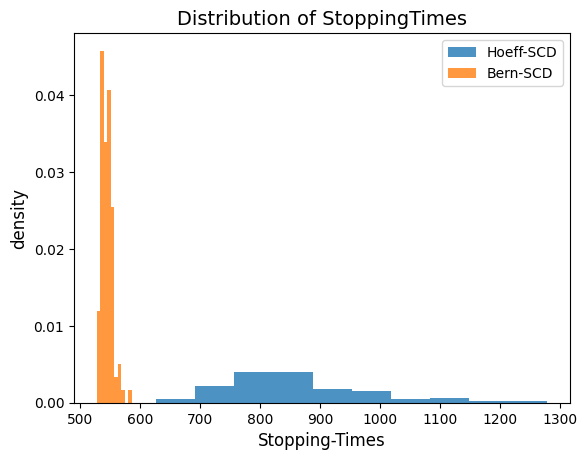

In [8]:
############## Experiment 2: Change in mean at a finite T ##############

# create the new source (now with a change in mean)
change_point = 500
Nmax = 2000
Delta = 0.40
mu0 = 0.5
mu1 = mu0 + Delta
source2 = createBoundedSource(change_point=change_point, mu0=mu0, mu1=mu1) 

# update the two change-detection-schemes 
HoeffSCD.source, HoeffSCD.Nmax = source2, Nmax 
BernSCD.source, BernSCD.Nmax = source2, Nmax
                        
# run the experiments 
num_trials=100
FlagH2, TimesH2 = HoeffSCD.run_expt(num_trials)
FlagB2, TimesB2 = BernSCD.run_expt(num_trials)

# plot the results 
AvgH, RejH = evaluateExpt(change_point, FlagH2, TimesH2)
AvgB, RejB = evaluateExpt(change_point, FlagB2, TimesB2)
print(f"Hoeff: Delay={AvgH}, Rej-Rate = {RejH}")
print(f"Bern: Delay={AvgB}, Rej-Rate = {RejB}")

plt.hist(TimesH2[FlagH2]-change_point, label='Hoeff-SCD', density=True, alpha=0.8)
plt.hist(TimesB2[FlagB2]-change_point, label='Bern-SCD', density=True, alpha=0.8)
plt.title("Distribution of Detection Delays", fontsize=14)
plt.xlabel("Detection-Delays", fontsize=12)
plt.ylabel("density", fontsize=12)
plt.legend()
plt.show()


In [9]:
############## Experiment 3: Delay vs Delta ##############

DELTA = np.array([0.15, 0.20, 0.25, 0.3, 0.35, 0.4])
Nmax = 2500 # increase the maximum horizon for one trial 
HoeffSCD.Nmax = Nmax 
BernSCD.Nmax = Nmax 
mu0 = 0.5
num_trials=20
AvgDelayH = np.zeros((len(DELTA), ))
AvgDelayB = np.zeros((len(DELTA), ))
for i, Delta in enumerate(DELTA): 
    # create the new source 
    mu1 = mu0 + Delta
    source_ = createBoundedSource(change_point=change_point, mu0=mu0, mu1=mu1)

    # update the change-detection schemes 
    HoeffSCD.source = source_
    BernSCD.source = source_

    # run the two algorithms 
    FlagH_, TimesH_ = HoeffSCD.run_expt(num_trials) 
    FlagB_, TimesB_ = BernSCD.run_expt(num_trials) 

    # get the average detection delays
    AvgDelayH[i], _ = evaluateExpt(change_point, FlagH_, TimesH_)
    AvgDelayB[i], _ = evaluateExpt(change_point, FlagB_, TimesB_)

plt.figure() 
plt.plot(DELTA, AvgDelayH, label='Hoeff-SCD')    
plt.plot(DELTA, AvgDelayB, label='Bern-SCD')    
plt.title('Variation of Delay with Delta', fontsize=14)
plt.xlable(r'Change in mean ($\Delta$)', fontsize=12)
plt.ylable(r'Average Detection Delay', fontsize=12)
plt.legend()
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]